In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import time
import math, time
from sklearn.metrics import mean_squared_error,r2_score
import plotly.express as px
import plotly.graph_objects as go
from utils import split_data
import argparse
import os
from model import *
from utils import *
from pathlib import Path

## 形参设定

In [2]:
parser = argparse.ArgumentParser()

# data
parser.add_argument('--path', type=str, default='../data/rlData.csv')
parser.add_argument('--vision', type=bool, default=True)
parser.add_argument('--input_features', type=list, default=['Open', 'High', 'Low', 'Volume', 'Close'])
parser.add_argument('--output_features', type=list, default=['Close','Open','High','Low'])
parser.add_argument('--window_size', type=int, default=20)
parser.add_argument('--train_test_ratio', type=float, default=0.2)
parser.add_argument('--random_state', type=int, default=34)

# model
parser.add_argument('--model_name', type=str, default='BiLSTM_ekan',help='selection from LSTM,LSTM_ekan,TCN_ekan,TCN,Transformer,Transformer_ekan,BiLSTM,BiLSTM_ekan,GRU,GRU_e_kan')
parser.add_argument('--dropout', type=float, default=0.2)
parser.add_argument('--hidden_dim', type=int, default=32)
parser.add_argument('--n_layers', type=int, default=2)

##kan
parser.add_argument('--grid_size', type=int, default=200,help='grid')


##TCN
parser.add_argument('--num_channels', type=list, default=[25, 50, 25])
parser.add_argument('--kernel_size', type=int, default=3)

##transformer
parser.add_argument('--num_heads', type=int, default=4)
parser.add_argument('--hidden_space', type=int, default=32)

# training
parser.add_argument('--num_epochs', type=int, default=300)
parser.add_argument('--seed', type=int, default=1)
# optimizer
parser.add_argument('--lr', type=float, default=5e-4, help='Adam learning rate')


args = parser.parse_args(args=[])
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



## 读取数据并查看

In [3]:
data = pd.read_csv(args.path)
##按照date的值进行排序
data = data.sort_values('Date')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-23,182.500000,186.910004,182.179993,186.899994,186.899994,16628100
1,2018-05-24,185.880005,186.800003,185.029999,185.929993,185.929993,12354700
2,2018-05-25,186.020004,186.330002,184.449997,184.919998,184.919998,10965100
3,2018-05-29,184.339996,186.809998,183.710007,185.740005,185.740005,16398900
4,2018-05-30,186.539993,188.000000,185.250000,187.669998,187.669998,13736900
...,...,...,...,...,...,...,...
247,2019-05-17,184.839996,187.580002,184.279999,185.300003,185.300003,10485400
248,2019-05-20,181.880005,184.229996,181.369995,182.720001,182.720001,10352000
249,2019-05-21,184.570007,185.699997,183.889999,184.820007,184.820007,7502800
250,2019-05-22,184.729996,186.740005,183.610001,185.320007,185.320007,9203300


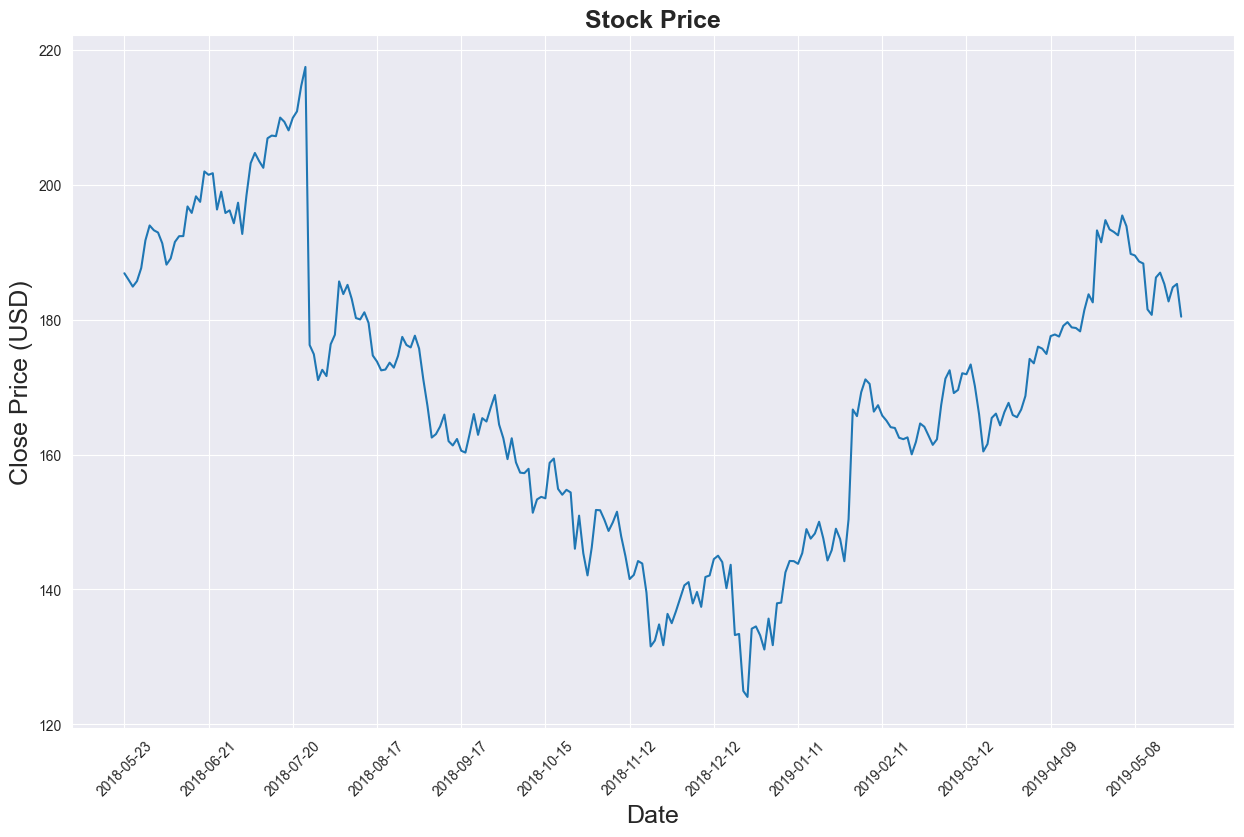

In [4]:
## 是否查看数据集可视化
if args.vision==True:
    sns.set_style("darkgrid")
    plt.figure(figsize=(15, 9))
    plt.plot(data[['Close']])
    plt.xticks(range(0, data.shape[0], 20), data['Date'].loc[::20], rotation=45)
    plt.title("Stock Price", fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price (USD)', fontsize=18)
    plt.show()
else:
    pass

## 确定特征值和目标值并进行特征尺度缩放

In [5]:
features = data[args.input_features]
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features)

target_scaler = MinMaxScaler(feature_range=(-1, 1))
target = data[args.output_features] 
target_scaled = target_scaler.fit_transform(target)  

one_scaler = MinMaxScaler(feature_range=(-1, 1))
one_scaled = one_scaler.fit_transform(data[['Open']])

## 建立变量和列索引的字典

In [6]:
output_colnames = args.output_features
param=list(output_colnames)
param_index=range(len(param))
param_index_dict=dict(zip( param_index,param))

## 进行数据集的划分

In [7]:
x_train, y_train, x_test, y_test = split_data(features_scaled , target_scaled,args.window_size )
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (186, 19, 5)
y_train.shape =  (186, 4)
x_test.shape =  (46, 19, 5)
y_test.shape =  (46, 4)


In [8]:
# 注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## 模型选择

In [9]:
if args.model_name=='LSTM':
    model = LSTM(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name=='LSTM_ekan':
    model = LSTM_ekan(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name=='BiLSTM':
    model = BiLSTM(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name=='BiLSTM_ekan':
    model = BiLSTM_ekan(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name=='GRU':
    model = GRU(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name=='GRU_ekan':
    model = GRU_ekan(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name=='TCN':
    model = TemporalConvNet(num_inputs=len(args.input_features), num_outputs=len(args.output_features) ,num_channels=args.num_channels, kernel_size=args.kernel_size, dropout=args.dropout)
elif args.model_name=='TCN_ekan':
    model=TemporalConvNet_ekan(num_inputs=len(args.input_features), num_outputs=len(args.output_features) ,num_channels=args.num_channels, kernel_size=args.kernel_size, dropout=args.dropout)
elif args.model_name=='Transformer':
    model = TimeSeriesTransformer(input_dim=len(args.input_features), num_heads=args.num_heads, num_layers=args.n_layers, num_outputs=len(args.output_features), hidden_space=args.hidden_space,dropout_rate=args.dropout)
elif args.model_name=='Transformer_ekan':
    model = TimeSeriesTransformer_ekan(input_dim=len(args.input_features), num_heads=args.num_heads, num_layers=args.n_layers, num_outputs=len(args.output_features), hidden_space=args.hidden_space,dropout_rate=args.dropout)
else:
    print('please choose correct model name')


## 进行训练

In [10]:
## 损失设定
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## 统计MSE均方误差和R2决定系数
MSE_hist = np.zeros(args.num_epochs)
R2_hist=np.zeros(args.num_epochs)

##开始时间统计和结果保存
start_time = time.time()
result = []

##循环训练
for t in range(args.num_epochs):
    y_train_pred = model(x_train)
##损失计算
    loss = criterion(y_train_pred, y_train)
##R2计算
    R2=r2_score(y_train_pred.detach().numpy(), y_train.detach().numpy())
    print("Epoch ", t, "MSE: ", loss.item(),'R2',R2.item())

#统计每个时间步的损失和R2指标
    MSE_hist[t] = loss.item()
    if R2 < 0:
        R2 = 0
    R2_hist[t]=R2
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    
training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2408011257648468 R2 -771537.3146423366
Epoch  1 MSE:  0.2286216914653778 R2 -51399.72003466007
Epoch  2 MSE:  0.21509507298469543 R2 -240279.35806050448
Epoch  3 MSE:  0.1953730583190918 R2 -1070.4329917373057
Epoch  4 MSE:  0.1699061095714569 R2 -89.5763377243174
Epoch  5 MSE:  0.1404937356710434 R2 -13.298390130361401
Epoch  6 MSE:  0.1109226793050766 R2 -2.0792494518344515
Epoch  7 MSE:  0.07415363937616348 R2 0.14520023797265313
Epoch  8 MSE:  0.08836468309164047 R2 0.47873591709347385
Epoch  9 MSE:  0.07859876751899719 R2 0.6174653979175817
Epoch  10 MSE:  0.05681405961513519 R2 0.7011360612813915
Epoch  11 MSE:  0.037868913263082504 R2 0.7624945488709003
Epoch  12 MSE:  0.029979700222611427 R2 0.7900391675834036
Epoch  13 MSE:  0.025627508759498596 R2 0.8141313273761213
Epoch  14 MSE:  0.021916205063462257 R2 0.8469237764622843
Epoch  15 MSE:  0.01911299116909504 R2 0.8799728155692492
Epoch  16 MSE:  0.017792649567127228 R2 0.9030191282640405
Epoch  17 MSE:  0.01

## 绘制结果实验图

Directory '../BiLSTM_ekan/train' already exists.
Directory '../BiLSTM_ekan/train' already exists.
Directory '../BiLSTM_ekan/train' already exists.
Directory '../BiLSTM_ekan/train' already exists.


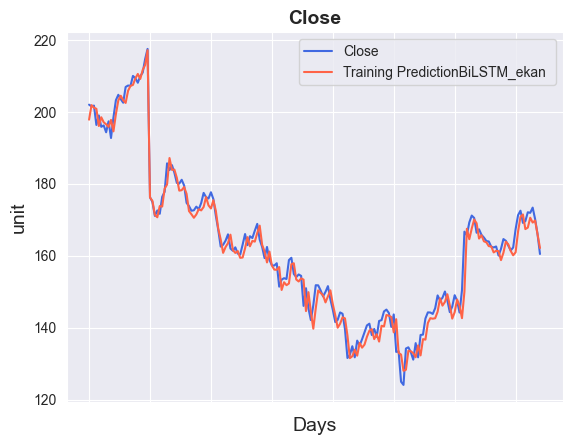

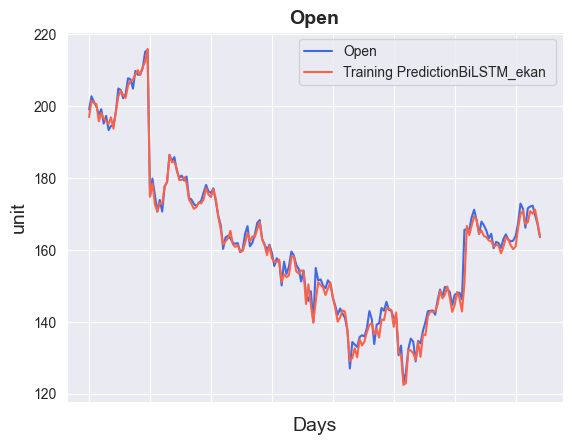

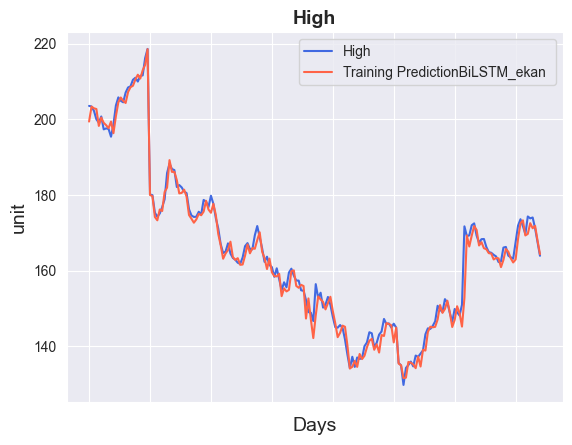

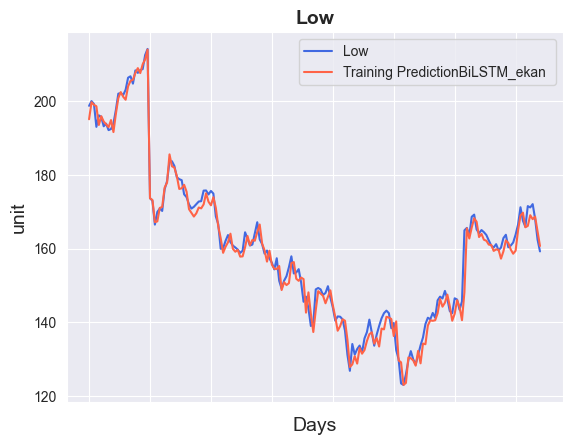

In [11]:
## 反缩放-恢复正常值
predict = pd.DataFrame(target_scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(target_scaler.inverse_transform(y_train.detach().numpy()))

##对每个预测单元进行绘图
for i in range(len(args.output_features)):
    sns.set_style("darkgrid")
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    # 计算当前组的行数和列数
   
    ax = sns.lineplot(x = range(len(original.index)), y = original.loc[:,i], label=f"{param_index_dict[i]}", color='royalblue')
    ax = sns.lineplot(x = range(len(predict.index)), y = predict.loc[:,i], label=f"Training Prediction{args.model_name} ", color='tomato')
    # print(predict.index)
    # print(predict[0])
    
    
    ax.set_title(f'{param_index_dict[i]}', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("unit", size = 14)
    ax.set_xticklabels('', size=10)
    
    
    Fitting_path=f'../{args.model_name}/train'
    if not os.path.exists(Fitting_path):
    # 使用 os.makedirs() 创建目录
        os.makedirs(Fitting_path)
        print(f"Directory '{Fitting_path}' was created.")
    else:
        print(f"Directory '{Fitting_path}' already exists.")

    plt.savefig(os.path.join(Fitting_path,f'{param_index_dict[i]}'))

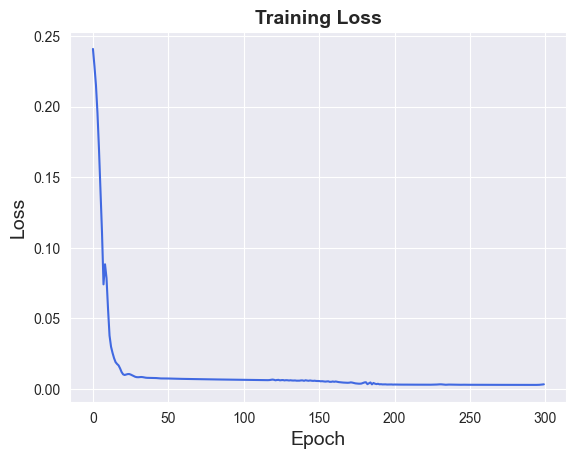

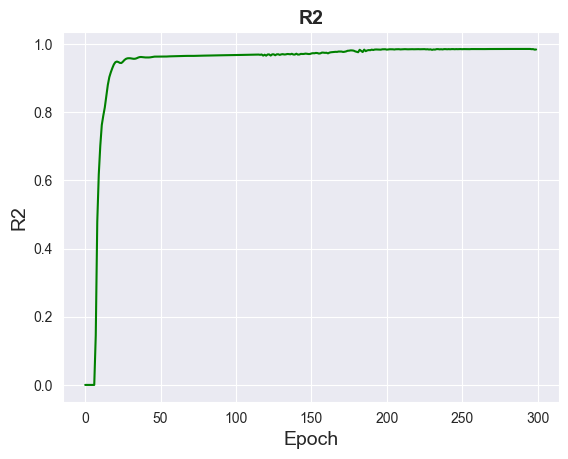

In [12]:
##绘制loss曲线和R2决定系数
indication_path=f'../{args.model_name}/train'
plt.plot()
ax = sns.lineplot(data=MSE_hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig(os.path.join(indication_path,'loss'))
plt.show()

plt.plot()
ax = sns.lineplot(data=R2_hist, color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("R2", size = 14)
ax.set_title("R2", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig(os.path.join(indication_path,'R2'))
plt.show()

## 进行模型测试

In [13]:
y_test_pred = model(x_test)
trainScore = mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy(),squared=False)
r2_train = r2_score(y_train.detach().numpy(), y_train_pred.detach().numpy())
print('Train Score: %.2f RMSE' % (trainScore))
print('Train R^2: %.2f' % (r2_train))
testScore = math.sqrt(mean_squared_error(y_test.detach().numpy(), y_test_pred.detach().numpy()))
r2_test = r2_score(y_test.detach().numpy(), y_test_pred.detach().numpy())
print('Test Score: %.2f RMSE' % (testScore))
print('Test R^2: %.2f' % (r2_test))
result.append(trainScore)
result.append(testScore)
result.append(training_time)

Train Score: 0.06 RMSE
Train R^2: 0.98
Test Score: 0.07 RMSE
Test R^2: 0.89


In [14]:
## 反缩放-恢复正常值
y_train_pred = target_scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = target_scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = target_scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = target_scaler.inverse_transform(y_test.detach().numpy())

## 将模型指标添加到model_scores的csv文件中

In [15]:
file_path = 'model_scores.csv'

# 创建一个包含当前模型结果的DataFrame
data = {
    "Train Score": [trainScore],
    "Train R^2": [r2_train],
    "Test Score": [testScore],
    "Test R^2": [r2_test]
}
df = pd.DataFrame(data, index=[args.model_name])

# 检查文件是否存在
if Path(file_path).exists():
    # 文件存在，追加数据
    df.to_csv(file_path, mode='a', header=False)
else:
    # 文件不存在，创建文件并写入数据
    df.to_csv(file_path)

## 绘制测试结果图

In [16]:
for i in range(len(args.output_features)):
    trainPredictPlot = np.empty_like(target_scaled[:,i]).reshape(-1,1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[args.window_size:len(y_train_pred)+args.window_size, :] = y_train_pred[:,i].reshape(-1,1)

    testPredictPlot = np.empty_like(target_scaled[:,i]).reshape(-1,1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(y_train_pred)+args.window_size-1:len(target_scaled[:,i])-1, :] = y_test_pred[:,i].reshape(-1,1)


    original = one_scaler.inverse_transform(target_scaled[:,i].reshape(-1,1))


    # 绘制图形
    plt.figure(figsize=(10, 6))
    plt.plot(trainPredictPlot, label='Train Prediction', linestyle='-', marker='', color='blue')
    plt.plot(testPredictPlot, label='Test Prediction', linestyle='-', marker='', color='green')
    plt.plot(original, label='Actual Values', linestyle='-', marker='', color='red')

    plt.title(f'Results ({param_index_dict[i]})')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    output_dir=f'../{args.model_name}/test'
    if not os.path.exists(output_dir):
    # 使用 os.makedirs() 创建目录
        os.makedirs(output_dir)
        print(f"Directory '{output_dir}' was created.")
    else:
        print(f"Directory '{output_dir}' already exists.")
    # 保存图像
    plt.savefig(os.path.join(output_dir, f'{param_index_dict[i]}.png'))
    plt.close()

    print(f"Plot for {param_index_dict[i]} saved in {os.path.join(output_dir, f'{param_index_dict[i]}.png')}")

Directory '../BiLSTM_ekan/test' already exists.
Plot for Close saved in ../BiLSTM_ekan/test\Close.png
Directory '../BiLSTM_ekan/test' already exists.
Plot for Open saved in ../BiLSTM_ekan/test\Open.png
Directory '../BiLSTM_ekan/test' already exists.
Plot for High saved in ../BiLSTM_ekan/test\High.png
Directory '../BiLSTM_ekan/test' already exists.
Plot for Low saved in ../BiLSTM_ekan/test\Low.png
